In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import os
import math

import src.utils as utils
from bimvee.importIitYarp import importIitYarp

In [2]:
## import data
sequence_name = "s1_v1"
path = os.path.join("/home/schiavazza/data/hpe/fault_button/osai/fault_button", sequence_name)

try:
    events = importIitYarp(filePathOrName=path)
except Exception as e:
    print("could not import data")
    print(e)
    exit

importIitYarp trying path: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1
Examining info.log: /home/schiavazza/data/hpe/fault_button/osai/fault_button/s1_v1/info.log


In [3]:
with open(path + "/positions.csv", newline='') as csvfile:
    positions = np.loadtxt(csvfile)
with open(path + "/timing_press.csv", newline='') as csvfile:
    press_timing = np.loadtxt(csvfile)

In [4]:
# the roi center is the button position
roi_center = [
    positions[0, [2, 4]].sum() / 2,
    positions[0, [1, 3]].sum() / 2
]
# the roi edge is manually selected close the the person
roi_edge = [
    positions[1, [2, 4]].sum() / 2,
    positions[1, [1, 3]].sum() / 2
]

Window size: [274, 372]
Detection threshold: 71349.6
Window size: [237, 298]
Detection threshold: 49438.200000000004
Window size: [181, 186]
Detection threshold: 23566.2
Window size: [111, 112]
Detection threshold: 8702.400000000001


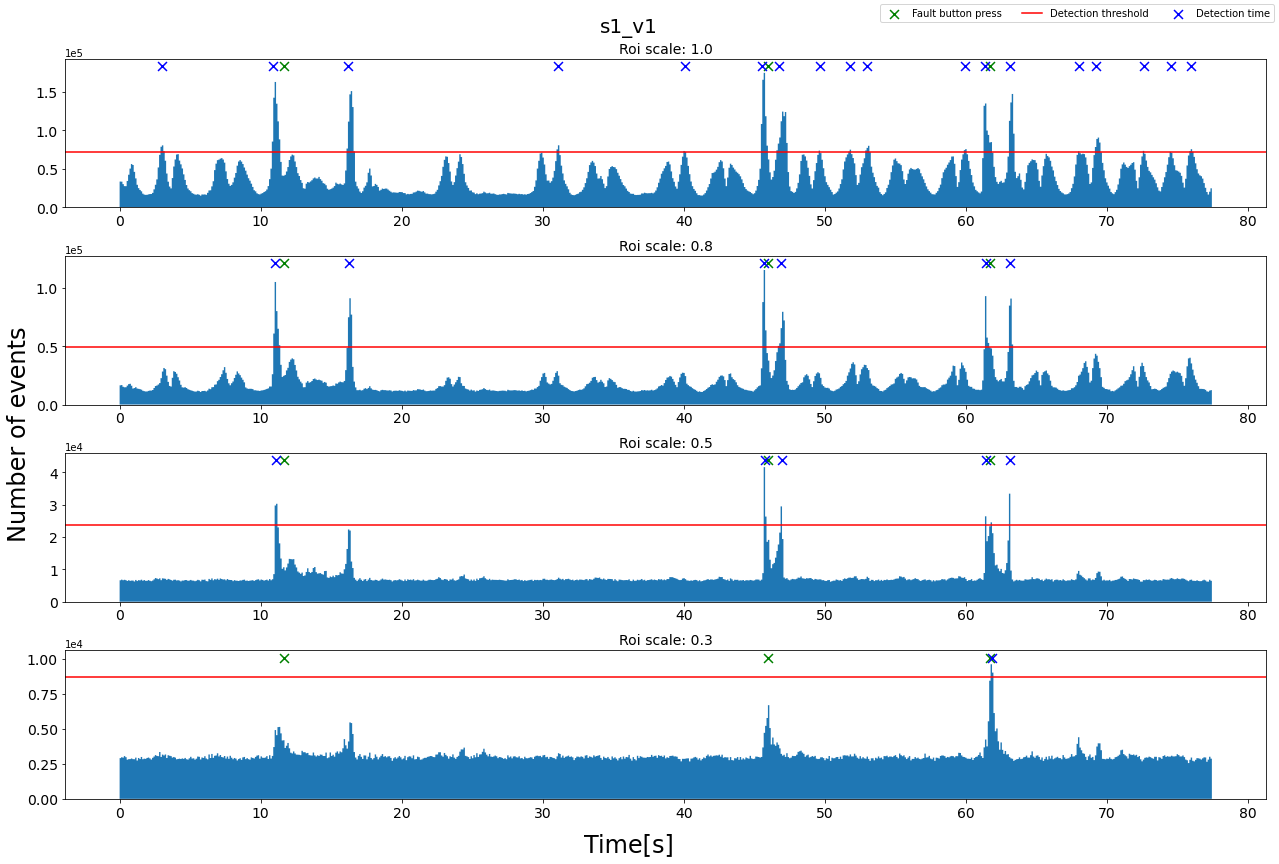

In [17]:
scales = [1.0, 0.8, 0.5, 0.3]
dataset_tres = 0.1
base_thresh = 7

fig, axs = plt.subplots(len(scales), 1, figsize=(18, 12))

for ax, scale in zip(axs, scales):

     # scale controlls the radius scale
    roi = utils.get_roi(roi_center, roi_edge, scale=scale)
    roi[0] = np.clip(roi[0], 0, 640) # hardcoded img resolution
    roi[1] = np.clip(roi[1], 0, 480)

    ts_filt, window_size = utils.get_events_roi(events, roi)

    h, bins, _ = utils.plot_hist(ax, ts_filt, dataset_tres)
    # get y val for markers to be on the top of the plot
    plt_y_lim = ax.get_ylim()
    v = plt_y_lim[1]

    detection_thresh = (base_thresh * dataset_tres) * (window_size[0] * window_size[1])

    utils.plot_press_times(ax, press_timing, yval=v)
    utils.plot_detections(ax, h, detection_thresh, bins, dataset_tres, yval=v)

    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.tick_params(labelsize=14)
    ax.set_title(f"Roi scale: {scale}", fontsize=14)

fig.suptitle(sequence_name, fontsize=20)
fig.supxlabel("Time[s]", fontsize=24)
fig.supylabel("Number of events", fontsize=24)

lines, labels = fig.axes[-1].get_legend_handles_labels()
plt.figlegend(lines,labels, ncol=3)

fig.tight_layout()


The threshold is manually picked and then scaled depending on the resolution used for the bins and the roi dimensions. There is not a single value that fits all the different roi sizes. From the plot is clear that bigger roi sizes increase the noise, while smaller sizes may not give reliable detection. The plots use the same detection threshold(normalized by the roi size) for all roi sizes.